## Visualizing Filters of a Convolutional Neural Network

## Modelin İndirilmesi

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random

Üst kısımda gerekli olacak kütüphaneler yükleniyor...

Alt kısımda ise VGG16 modelini keras aracılığıyla alıp istediğimiz paramatreleri belirliyoruz.

**include_top**: fully-connected layer olarak adlandırılan katmanları göstermek isteyip istemediğimizi belirtiyoruz.

**weights**: weights'leri imagenet datasetinin ağırlıkları olarak belirliyoruz.

**input_shape**: Girdi shape'imizi belirtiyoruz.


In [ ]:
model=tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3)
)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

## Alt Katmanları İncelemek

Alttaki fonksiyonda üstte belirlediğimiz kendi modelimizin inputlarını submodelle aynı yapıp katman adına göre çıktılarını alıyoruz...

In [ ]:
def get_submodel(layer_name):
  return tf.keras.models.Model(
      model.input,
      model.get_layer(layer_name).output
  )
get_submodel('block1_conv2').summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


## Fotoğraf Görselleştirme

**create_image()**: Burada *tf.random.uniform()* ile shape'ini belirleyerek rastgele dağılmış bir tensor elde ediyoruz.

**plot_image()**: Burada belirli işlemlerle beraber kendimize scale edilen bir fotoğraf bastırmayı amaçlıyoruz.

In [ ]:
def create_image():
  return tf.random.uniform((96,96,3))
def plot_image(image,title='random'):
  image=image-tf.math.reduce_min(image)
  image=image/tf.math.reduce_max(image)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  plt.show()

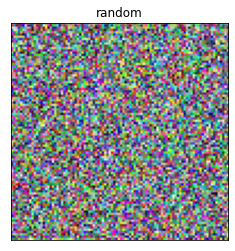

In [ ]:
plot_image(create_image())

## Eğitim Fonksiyonu

In [ ]:
def visualize_filter(layer_name,f_index=None,iters=50):
  submodel=get_submodel(layer_name)                       #Submodelimizi alıyoruz
  num_filters=submodel.output.shape[-1]                   #Kaç tane filtremiz olduğunu alıyoruz 

  if f_index is None:                                   
    f_index=random.randint(0,num_filters-1)               #Eğer f_index verilmediyse biz rastgele bir değer seçiyoruz
  assert num_filters>f_index,'f_indesx is out of bounds'  #Hata olduğunda çıkacak mesaj için

  image=create_image()                                    #Fotoğrafımızın sabit kalması için değişkene atıyoruz
  verbose_step=int(iters/10)                              #Iterasyonu takip etmek için
  for i in range(0,iters):
    with tf.GradientTape() as tape:                       #Burada tf.GradientTape ile image'ı izliyoruz
      tape.watch(image)                                   #Buradaki mantık loss olarak belirlediğimiz değeri olabiliğince
                                                          #maximize edebilmektir
      out=submodel(tf.expand_dims(image,axis=0))[:,:,:,f_index]
      loss=tf.math.reduce_mean(out)                       #ortalama ile loss'u belirliyoruz
    grads=tape.gradient(loss,image)
    grads=tf.math.l2_normalize(grads)
    image+=grads*10

    if (i+1)%verbose_step==0:
      print(f'iteration: {i+1},Loss:{loss.numpy():.4f}')
  plot_image(image,f'{layer_name},{f_index}')

## Sonuçlar

Burada submodel olarak alabileceğimiz katmanları görüyoruz.

In [ ]:
print([layer.name for layer in model.layers if 'conv' in layer.name]) 

['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']


Colab kullananlar için seçerek parametre değiştirmek içindir...

In [ ]:
layer_name='block1_conv1'#@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']


iteration: 5,Loss:0.8922
iteration: 10,Loss:1.3125
iteration: 15,Loss:1.7850
iteration: 20,Loss:2.2868
iteration: 25,Loss:2.8095
iteration: 30,Loss:3.3479
iteration: 35,Loss:3.8957
iteration: 40,Loss:4.4511
iteration: 45,Loss:5.0125
iteration: 50,Loss:5.5782


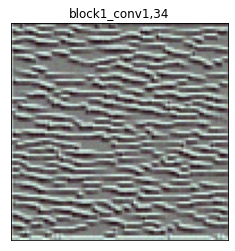

In [ ]:
visualize_filter(layer_name)